### Import relevant packages

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('clarke-default')
import matplotlib.dates as mdates
import csv
import pandas as pd
import datetime
import sys
sys.path.insert(0,'../../Scripts/')
from ElectronAttachment.ElectronAttachment import Concentration
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import interpolate
from scipy import stats as st
from scipy.integrate import cumtrapz

### Define constants and set experimental parameters

In [28]:
# xenon properies
rhoXeSTP = 5.894 # xenon density at STP, g/L
mXe = 131.29 # xenon molar mass, g/mol
mLXe = 1500. # total liquid xenon mass, g

# experimental setup
saes = False # different datasets for SAES data and SCP data
Vdrift = 250 # drift field, V/cm
Pxenon = 1900 # average xenon pressure [torr], used to convert EL -> concentration

# recirculation during purification
VDot = 1.34 # xenon flow rate, SLPM
if saes:
    VDot = 1.21 # xenon flow rate, SLPM # 1.17
mDot = VDot*rhoXeSTP/60. # xenon mass flow rate, g/s
tauC = mLXe/mDot # total mass over mass flow rate, ie LXe turnover time [s]

# recirculation during dosing
VDotBypass = 0.45 # xenon flow rate, SLPM
mDotBypass = VDotBypass*rhoXeSTP/60. # xenon mass flow rate, g/s
tauCBypass = mLXe/mDotBypass # total mass ov mass flow rate, ie LXe turnover time [s]

### Define functions used to calculate electron lifetime and uncertainties

Electron lifetime is given by: $$ \tau = \frac{t_A-t_C}{\log{\left|\frac{Q_C}{Q_A}\right|}} $$

In [29]:
def EL(ta,tc,Qa,Qc):
    # Return electron lifetime for given cathode and anode voltages
    # if either the cathode or anode amplitude is negative, return 0
    el = (ta-tc)/np.log(Qc/Qa)
    if isinstance(el,np.float64):
        if Qc<0 or Qa<0:
            return 0
        else:
            return el
    el[(Qc<0) | (Qa<0)] = 0
    return el

def EL_error(ta,tc,Qa,Qc,dQa,dQc):
    # Calculate standard error on electron lifetime. Not valid for large
    # lifetimes due to highly asymmetric distribution
    return ((ta-tc)/np.log(Qc/Qa)**2)*np.sqrt((dQc/Qc)**2+(dQa/Qa)**2)

def get_EL_mc(index):
    # Create MC distribution of EL values using uncertainties
    # on anode and cathode voltages
    Qc_meas = data['Cathode'][index]
    Qa_meas = data['Anode'][index]
    Qc_mc = np.random.normal(Qc_meas,Q_err,num_mc)
    Qa_mc = np.random.normal(Qa_meas,Q_err,num_mc)
    EL_meas = []
    for Qa_val in Qa_mc:
        for Qc_val in Qc_mc:
            EL_meas.append(EL(ta,tc,Qa_val,Qc_val))
    EL_meas = np.array(EL_meas)
    EL_meas = np.delete(EL_meas,EL_meas<0)
    EL_meas = np.delete(EL_meas,EL_meas>100000)
    return Qa_meas,Qc_meas,EL_meas
            
def combine_mc_dists(dists):
    # For a single set of acquisitions, combine and histogram
    # the EL distributions
    EL_meas = []
    Qa_meas = []
    Qc_meas = []
    for i in range(len(dists)):
        EL_meas.append(dists[i][2])
        Qa_meas.append(dists[i][0])
        Qc_meas.append(dists[i][1])
    return np.array(Qa_meas),np.array(Qc_meas),np.concatenate(EL_meas)

def get_EL_uncertainties(dist):
    # Get median and uncertainties for a distribution of EL values
    Qa_meas, Qc_meas, EL_meas = dist
    lower_bin = np.mean(EL_meas) - 3*np.std(EL_meas)
    upper_bin = np.mean(EL_meas) + 3*np.std(EL_meas)
    if lower_bin<0: # or lower_bin>100000:
        lower_bin = 0
    if upper_bin>100000: #<0:
        upper_bin = 100000
    bin_array = np.linspace(lower_bin,upper_bin,100)
    cts,edges = np.histogram(EL_meas,bins=bin_array,density=True)
    bins = (edges[:-1]+edges[1:])/2.
    lower = bins[np.argmin(abs(cumtrapz(cts,bins)-0.16))]
    upper = bins[np.argmin(abs(cumtrapz(cts,bins)-0.84))]
    mode = bins[np.argmin(abs(cumtrapz(cts,bins)-0.5))]
    #mode = bins[np.argmax(cts)]
    return mode, mode-lower, upper-mode

def get_conc_uncertainties(dist):
    # Get median and uncertainties for a distribution of concentration values
    Qa_meas, Qc_meas, EL_meas = dist
    conc_meas = Concentration(EL_meas,Vdrift,Pxenon)
    conc_meas[EL_meas==0] = 1e9
    lower_bin = np.mean(conc_meas) - 3*np.std(conc_meas)
    upper_bin = np.mean(conc_meas) + 3*np.std(conc_meas)
    if lower_bin<0: # or lower_bin>100000:
        lower_bin = 0
    #if upper_bin>100000: #<0:
    #    upper_bin = 100000
    bin_array = np.linspace(lower_bin,upper_bin,100)
    cts,edges = np.histogram(conc_meas,bins=bin_array,density=True)
    bins = (edges[:-1]+edges[1:])/2.
    lower = bins[np.argmin(abs(cumtrapz(cts,bins)-0.16))]
    upper = bins[np.argmin(abs(cumtrapz(cts,bins)-0.84))]
    mode = bins[np.argmin(abs(cumtrapz(cts,bins)-0.5))]
    #mode = bins[np.argmax(cts)]
    return mode, mode-lower, upper-mode

def chi2(data,model,error):
    # Return chi2 for a fit
    return np.sum((data - model)**2/error**2)

def chi2_asymm(data,model,errorLower,errorUpper):
    # Return chi2 for a fit to data with asymmetric errors
    errorLower[model>data] = errorUpper[model>data]
    return np.sum((data - model)**2/errorLower**2)

def driver_function(params,xobs,yobs,yerrlower,yerrupper,fitfunc):
    # Returns the chi2 to be minimized for an arbitrary fitting function
    ynew = fitfunc(xobs,*params)
    return chi2_asymm(yobs,ynew,yerrlower,yerrupper)

### Read in raw data from the text file

In [30]:
headers= ['Tc','Ta','Tcrise','Tarise','Cathode','Anode','Offset',\
          'LVTimestamp','UV','IR','chi2','Nwaveforms','Ntriggers']

data = []

textfileSAES = ['../XPM_data/saes_dose1.txt','../XPM_data/saes_postdose1.txt']
textfileSCP = ['../XPM_data/scp_dose2.txt','../XPM_data/scp_postdose2.txt']

both = True
if saes:
    textfile = textfileSAES
if both:
    textfile = textfileSAES + textfileSCP

for file in textfile:
    with open(file,'r') as infile:
        reader = csv.reader(infile)
        for line in reader:
            data.append(line)
        
data = pd.DataFrame(data,columns=headers,dtype=float)

data['EL'] = EL(data['Ta'],data['Tc'],data['Anode'],data['Cathode'])
data['Time'] = [datetime.datetime.fromtimestamp(time-2335132800)\
                for time in data['LVTimestamp'].values]
data['Timestamp'] = [datetime.datetime.timestamp(time) for time in data['Time']]
print(data.head())

     Tc    Ta  Tcrise  Tarise    Cathode      Anode     Offset   LVTimestamp   
0  10.0  81.9     1.0     2.9  20.268782  19.531205  43.536735  4.012833e+09  \
1  10.0  81.9     1.0     2.9  20.384804  19.736552  41.918008  4.012833e+09   
2  10.0  81.9     1.0     2.9  21.288656  20.784401  42.207501  4.012833e+09   
3  10.0  81.9     1.0     2.9  22.869499  21.762862  45.218376  4.012834e+09   
4  10.0  81.9     1.0     2.9  24.199012  23.320212  42.650122  4.012834e+09   

           UV          IR      chi2  Nwaveforms  Ntriggers           EL   
0  266.875000  416.875000  4.483242       128.0       18.0  1939.656089  \
1  269.687500  423.515625  1.583693       128.0      132.0  2224.809528   
2  281.640625  439.296875  2.317399       128.0      131.0  2999.383197   
3  279.062500  435.625000  1.674096       128.0      131.0  1449.621257   
4  296.093750  480.625000  2.224121       128.0      168.0  1943.697463   

                 Time     Timestamp  
0 2023-03-01 11:49:58  1.67770

/Users/clarke/Documents/Research/nEXO/Scripts/nexo-env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Reduce the raw data to an EL value and concentration for each series of measurements

In [31]:
num_mc = 100 # number of normally-distributed points around each Qc or Qa measurement
             # used to compute distribution of EL values
Q_err = 0.1 # 0.2 mV, error on cathode and anode signals
ta = data['Ta'][0] # times should all be the same, so just take the first entry
tc = data['Tc'][0]

reduced_headers = ['EL','ELErrorLower','ELErrorUpper','Concentration','ConcentrationErrorLower',\
                   'ConcentrationErrorUpper','Cathode','Anode','Timestamp','Time']
reduced = []

# find groups of 10 closely-spaced events; if continuous data taking, group into
# tens starting from the first event
next_index = 10
for i in range(len(data.index)):
    if i==next_index:
        for j in range(10):
            if data['Timestamp'][j+i-9]-data['Timestamp'][j+i-10] < 300:
                next_index = i+j+1
            else:
                next_index += 1
                break
        evt_group = np.arange(i-10,next_index-10)
        this_group = []
        for j in evt_group:
            this_group.append(get_EL_mc(j))
        this_group = combine_mc_dists(this_group)
        modeEL, minus1sEL, plus1sEL = get_EL_uncertainties(this_group)
        modeConc, minus1sConc, plus1sConc = get_conc_uncertainties(this_group)
        this_timestamp = np.mean(data['Timestamp'][i-10:next_index-10])
        this_time = datetime.datetime.fromtimestamp(this_timestamp)
        cathode = np.mean(data['Cathode'][i-10:next_index-10])
        anode = np.mean(data['Anode'][i-10:next_index-10])
        reduced.append([modeEL,minus1sEL,plus1sEL,modeConc,minus1sConc,plus1sConc,\
                        cathode,anode,this_timestamp,this_time])
        
reduced = pd.DataFrame(reduced,columns=reduced_headers)#,dtype=float)
        
print(reduced.head())

/var/folders/7j/dr4jyt_56g3ccfjw_z3l9n640000gn/T/ipykernel_12039/2946454784.py:4: RuntimeWarning: invalid value encountered in log
  el = (ta-tc)/np.log(Qc/Qa)
../../Scripts/ElectronAttachment/ElectronAttachment.py:49: RuntimeWarning: divide by zero encountered in divide
  return 1e9/(RateConstant(Efield)*LXeDensity(pressure)*EL*1e-6)


            EL  ELErrorLower  ELErrorUpper  Concentration   
0  2144.911918    588.799350   1429.941279       0.176326  \
1  2754.577609    409.129865    579.600642       0.142159   
2  2621.351400    565.158493    565.158493       0.148248   
3  2497.118308    400.652261    427.362412       0.157146   
4  2643.410280    306.018922    442.027331       0.148717   

   ConcentrationErrorLower  ConcentrationErrorUpper    Cathode      Anode   
0                 0.072047                 0.064463  25.461551  24.678627  \
1                 0.024391                 0.025916  33.981970  33.127674   
2                 0.027886                 0.040757  50.694449  49.316787   
3                 0.023648                 0.030405  49.717879  48.293669   
4                 0.022791                 0.018518  48.254349  47.005545   

      Timestamp                    Time  
0  1.677701e+09 2023-03-01 12:05:18.300  
1  1.677702e+09 2023-03-01 12:25:31.000  
2  1.677714e+09 2023-03-01 15:47:39.100  
3 

### Plot an overview of the full run

/var/folders/7j/dr4jyt_56g3ccfjw_z3l9n640000gn/T/ipykernel_12039/1040140094.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(),rotation=60)


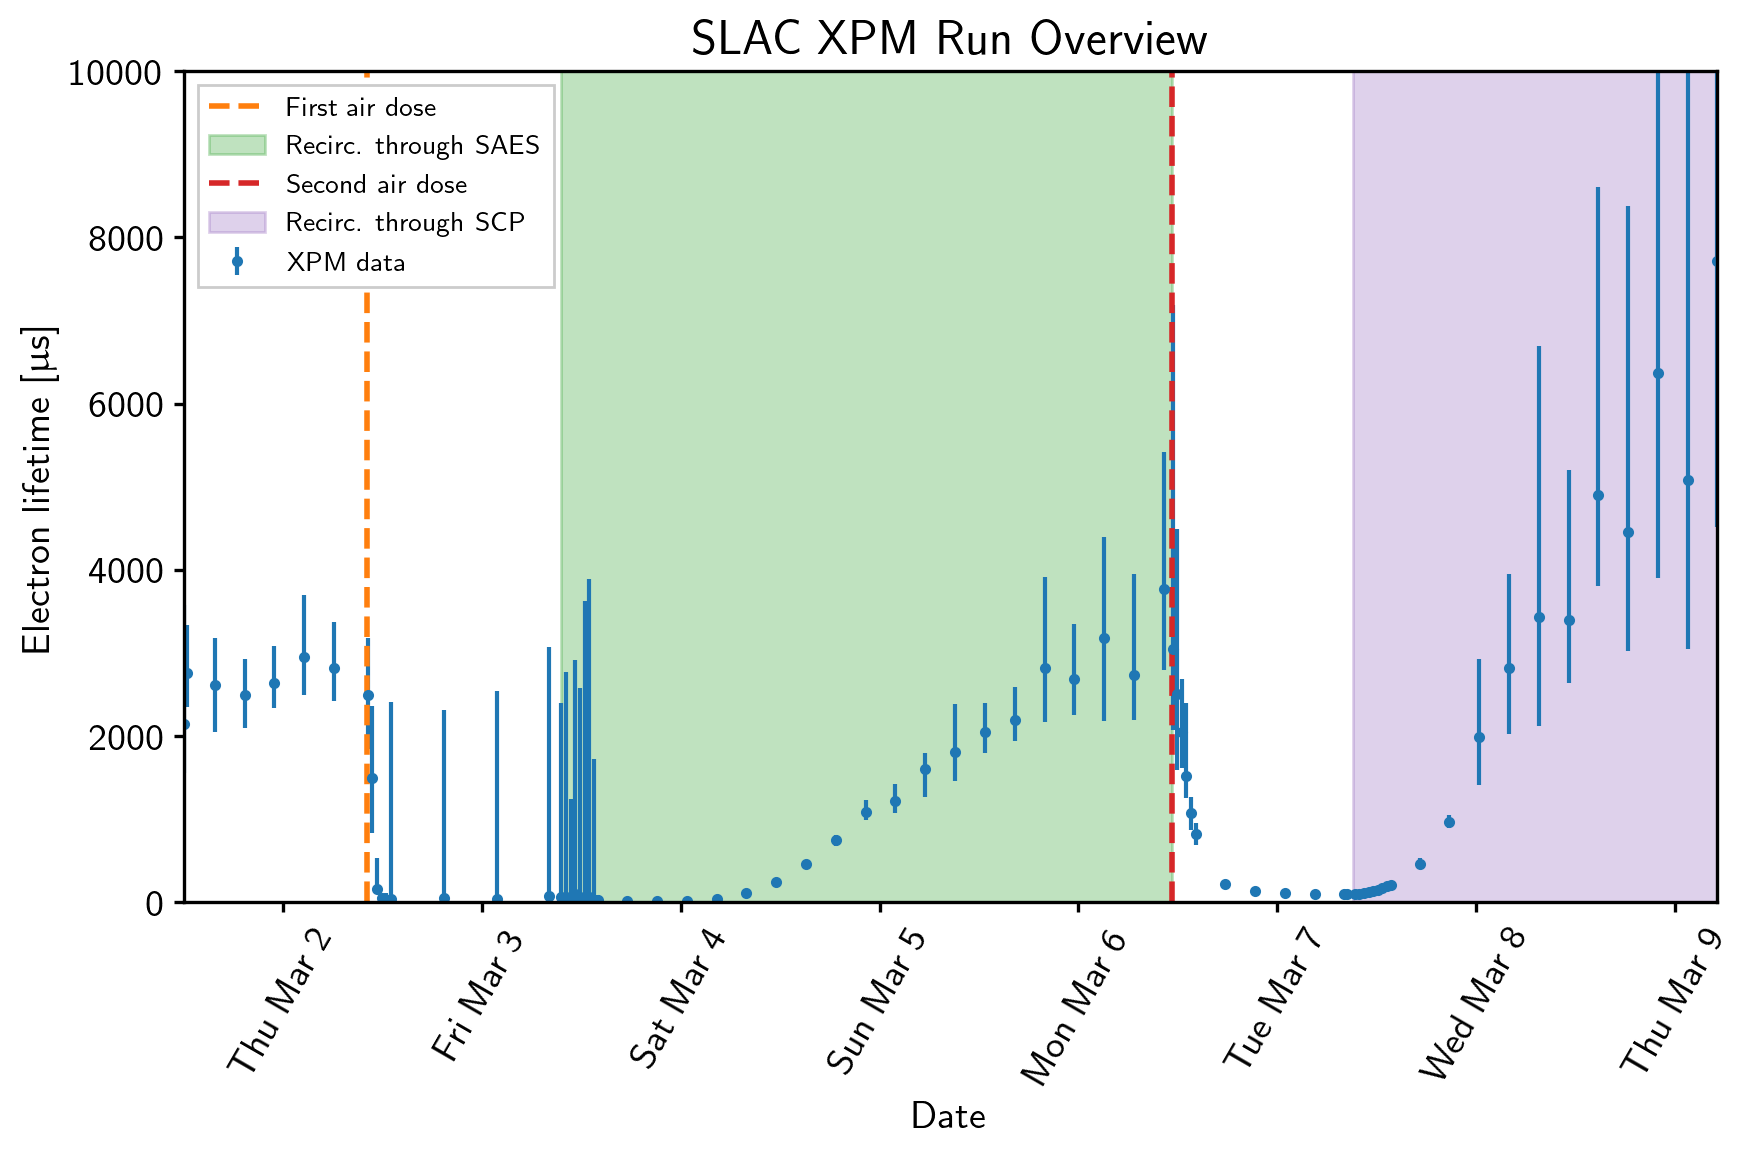

In [32]:
run_start = reduced['Time'].values[0]
dose1 = datetime.datetime(2023,3,2,10,9)
saes_start = datetime.datetime(2023,3,3,9,34)
dose2 = datetime.datetime(2023,3,6,11,15)
scp_start = datetime.datetime(2023,3,7,9,10)
run_end = reduced['Time'].values[-1]

fig,ax = plt.subplots(figsize=(9,6))
#ax.plot(data['Time'],data['EL'],'.')
ax.errorbar(reduced['Time'],reduced['EL'],yerr=[reduced['ELErrorLower'],reduced['ELErrorUpper']],fmt='.',label='XPM data')
ax.axvline(dose1,lw=2,ls='--',color=next(ax._get_lines.prop_cycler)['color'],label='First air dose')
ax.axvspan(saes_start,dose2,color=next(ax._get_lines.prop_cycler)['color'],alpha=0.3,ls=None,label='Recirc. through SAES')
ax.axvline(dose2,lw=2,ls='--',color=next(ax._get_lines.prop_cycler)['color'],label='Second air dose')
ax.axvspan(scp_start,run_end,color=next(ax._get_lines.prop_cycler)['color'],alpha=0.3,ls=None,label='Recirc. through SCP')
ax.set_xlabel('Date')
ax.set_ylabel('Electron lifetime [$\mu$s]')
ax.set_xticklabels(ax.get_xticks(),rotation=60)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %b %-d'))# %H:%M'))
ax.set_ylim([0,10000])
ax.set_xlim([run_start,run_end])
ax.set_title('SLAC XPM Run Overview')
ax.legend(loc='upper left',framealpha=1.)
# fig.savefig('Figures/run_overview.png')
plt.show()

1677672318.3000002
1677780540.0
Initial O2 concentration: 0.16 ppb
Constant O2 addition rate: -1.02+/-1.68 ppt/hour
chi2/ndof: 0.65/4


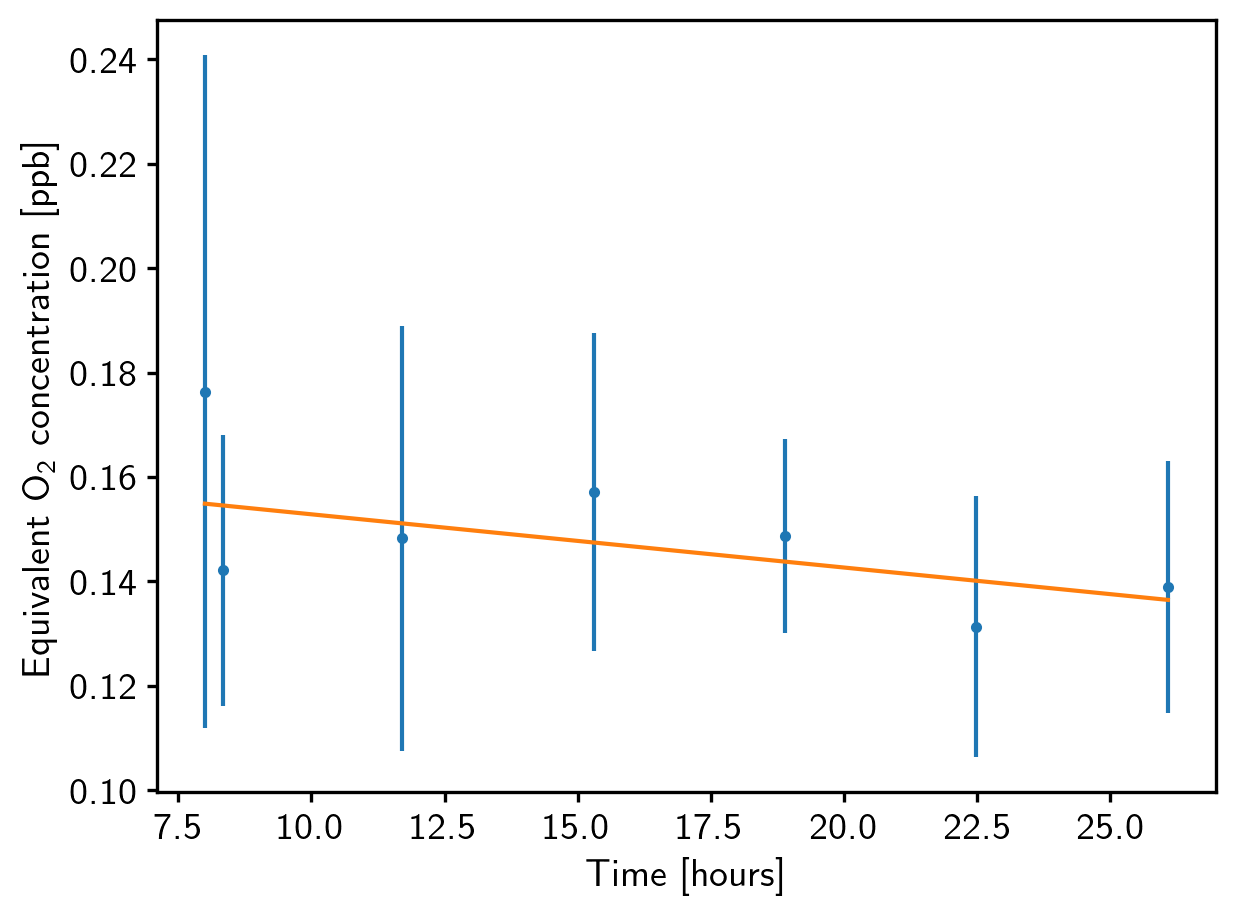

In [33]:
%matplotlib inline

def OutgassingModel(t,x0,Lambda):
    return x0+Lambda*t
p0 = [1.,1e-3]

outgasStart = run_start.astype(datetime.datetime)*1e-9
outgasEnd = datetime.datetime.timestamp(dose1)

print(outgasStart)
print(outgasEnd)

outgasTimes = reduced['Timestamp'][(reduced['Timestamp']>outgasStart) \
                                & (reduced['Timestamp']<outgasEnd)].values-outgasStart
outgasConcs = reduced['Concentration'][(reduced['Timestamp']>outgasStart) \
                                    & (reduced['Timestamp']<outgasEnd)].values
outgasConcErrorsLower = reduced['ConcentrationErrorLower'][(reduced['Timestamp']>outgasStart) \
                                              & (reduced['Timestamp']<outgasEnd)].values
outgasConcErrorsUpper = reduced['ConcentrationErrorUpper'][(reduced['Timestamp']>outgasStart) \
                                              & (reduced['Timestamp']<outgasEnd)].values
outgasConcErrors = (outgasConcErrorsLower + outgasConcErrorsUpper)/2.

p,c = curve_fit(OutgassingModel,outgasTimes,outgasConcs,sigma=outgasConcErrors,absolute_sigma=True,\
                p0=p0)

res = minimize(driver_function,p0,args=(outgasTimes,outgasConcs,outgasConcErrorsLower,\
                                        outgasConcErrorsUpper,OutgassingModel))
p = res.x

#KH = 60
Lambda = np.copy(p[1])#*KH

print('Initial O2 concentration: {:.2f} ppb'.format(p[0]))
print('Constant O2 addition rate: {:.2f}+/-{:.2f} ppt/hour'.format(Lambda*3600.*1e3,np.sqrt(c[1][1])*3600.*1e3))

chi2Outgas = chi2_asymm(outgasConcs,OutgassingModel(outgasTimes,*p),outgasConcErrorsLower,outgasConcErrorsUpper)
print('chi2/ndof: {:.2f}/{:.0f}'.format(chi2Outgas,len(outgasConcs)-len(p)-1))

outgasTimeArray = np.linspace(outgasTimes[0],outgasTimes[-1],1000)
outgasConcArray = OutgassingModel(outgasTimeArray,*p)

fig,ax = plt.subplots()
ax.errorbar(outgasTimes/3600.,outgasConcs,yerr=[outgasConcErrorsLower,outgasConcErrorsUpper],fmt='.')
ax.errorbar(outgasTimeArray/3600.,outgasConcArray)
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Equivalent O$_2$ concentration [ppb]')
# fig.savefig('outgassing.png',bbox_inches='tight')
plt.show()

[0.2033157  0.11147176 0.19153745]
[0.0248852  0.01888812 0.00156711]
Initial O2 concentration: 0.57+/-0.02 ppb
Equilibration factor: 1.484+/-0.002
Final O2 concentration: 4.41+/-0.02 ppb
chi2/ndof: 0.74/2


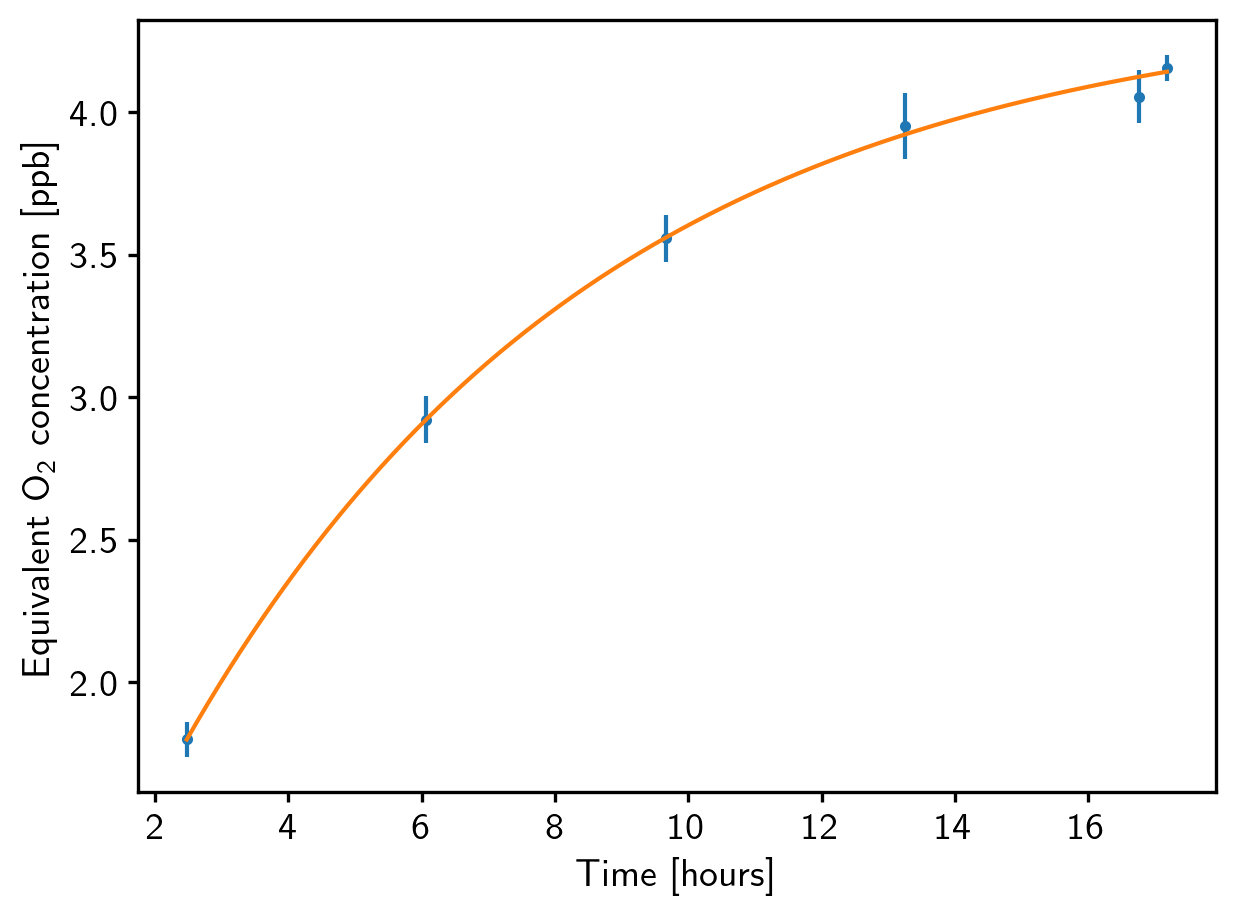

In [34]:
def DosingModel(t,x0,xd,f):
    #return xf-x0*np.exp(-f*t/tauCBypass)+Lambda*tauCBypass/f
    #return xf*(1-np.exp(-f*t/tauCBypass))+x0+Lambda*tauCBypass/f/KH
    return xd + (x0 - xd)*np.exp(-f*t/tauCBypass) + Lambda*tauCBypass/f
p0 = [1.,10.,1.]

dosingStart = datetime.datetime.timestamp(datetime.datetime(2023,3,6,15,15))
dosingEnd = datetime.datetime.timestamp(scp_start)

dosingTimes = reduced['Timestamp'][(reduced['Timestamp']>dosingStart) \
                                   & (reduced['Timestamp']<dosingEnd)].values-dosingStart
dosingConcs = reduced['Concentration'][(reduced['Timestamp']>dosingStart) \
                                       & (reduced['Timestamp']<dosingEnd)].values
dosingConcErrorsLower = reduced['ConcentrationErrorLower'][(reduced['Timestamp']>dosingStart) \
                                                           & (reduced['Timestamp']<dosingEnd)].values
dosingConcErrorsUpper = reduced['ConcentrationErrorUpper'][(reduced['Timestamp']>dosingStart) \
                                                           & (reduced['Timestamp']<dosingEnd)].values
dosingConcErrors = (dosingConcErrorsLower + dosingConcErrorsUpper)/2.

p,c = curve_fit(DosingModel,dosingTimes,dosingConcs,sigma=dosingConcErrors,absolute_sigma=True,\
                p0=p0)
print(np.sqrt(np.diag(c)))

res = minimize(driver_function,p0,args=(dosingTimes,dosingConcs,dosingConcErrorsLower,\
                                        dosingConcErrorsUpper,DosingModel),tol=1e-8)
p = res.x
c = np.sqrt(np.diag(res.hess_inv))
print(c)

print('Initial O2 concentration: {:.2f}+/-{:.2f} ppb'.format(p[0],c[0]))
print('Equilibration factor: {:.3f}+/-{:.3f}'.format(p[2],c[2]))
print('Final O2 concentration: {:.2f}+/-{:.2f} ppb'.format(p[1],c[1]))

chi2Dosing = chi2_asymm(dosingConcs,DosingModel(dosingTimes,*p),dosingConcErrorsLower,dosingConcErrorsUpper)
print('chi2/ndof: {:.2f}/{:.0f}'.format(chi2Dosing,len(dosingConcs)-len(p)-1))

f_dose = p[2]
df_dose = c[2]
#print('Constant O2 addition rate: {:.2e} ppb/hour'.format(p[3]*p[1]*3600.))

dosingTimeArray = np.linspace(dosingTimes[0],dosingTimes[-1],1000)
dosingConcArray = DosingModel(dosingTimeArray,*p)

fig,ax = plt.subplots()
ax.errorbar(dosingTimes/3600.,dosingConcs,yerr=[dosingConcErrorsLower,dosingConcErrorsUpper],fmt='.')
ax.errorbar(dosingTimeArray/3600.,dosingConcArray)
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Equivalent O$_2$ concentration [ppb]')
fig.savefig('dosing.png',bbox_inches='tight')

Initial O2 concentration: 34.82+/-1.72 ppb
Equilibration factor times efficiency: 0.74+/-0.02
Constant O2 addition rate: 56.560+/-11.248 ppt/hour
chi2/ndof: 2.41/3
prob: 4.9264e-01


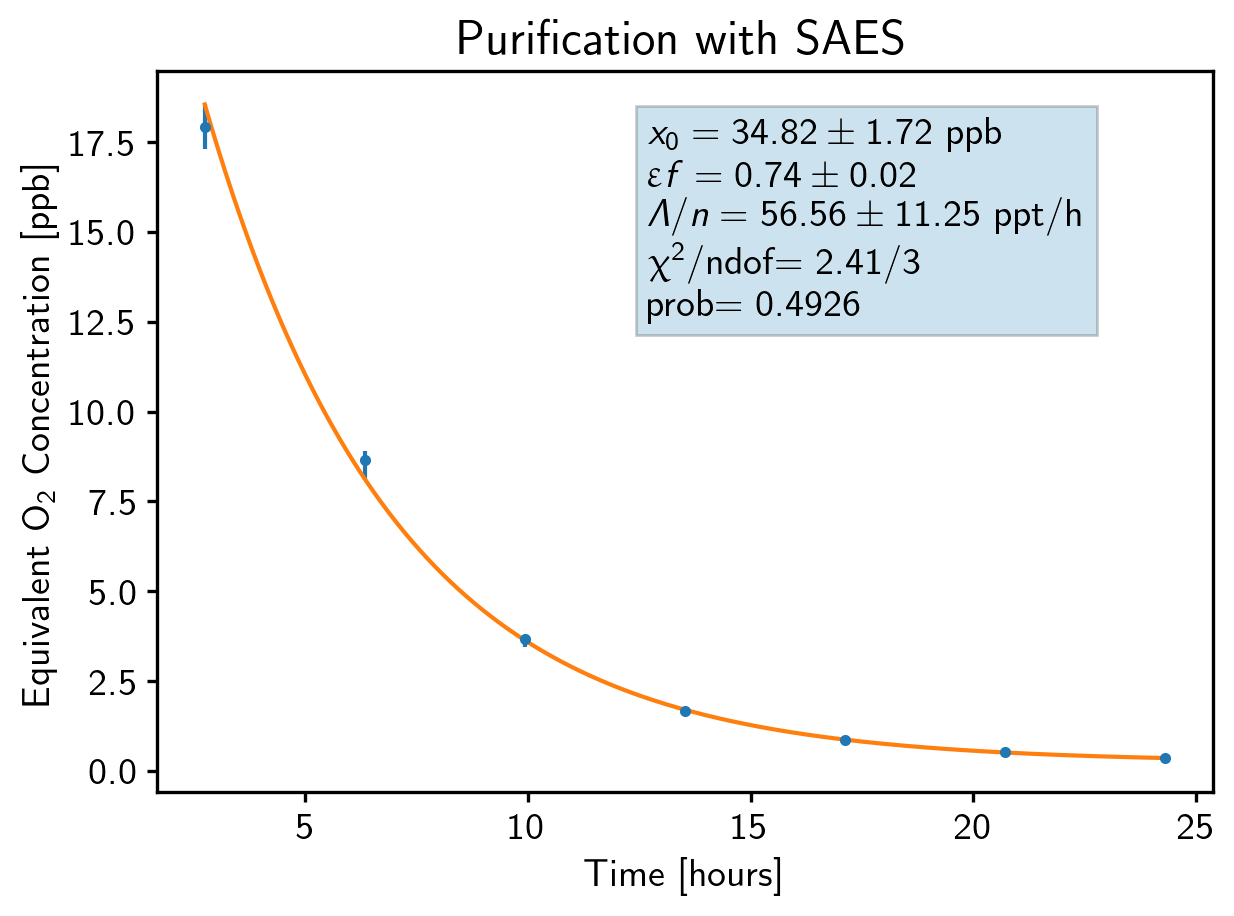

In [35]:
def ConcentrationModel(t,x0,ef,Lambda):
    return x0*np.exp(-ef*t/tauC)+Lambda*tauC/ef
p0 = [8.,1.0,1.]

saes = True

fitStart = datetime.datetime.timestamp(datetime.datetime(2023,3,7,9,30)) #datetime.datetime(2022,11,8,13,25))
fitEnd = datetime.datetime.timestamp(datetime.datetime(2023,3,8,9,30)) #9 10 #datetime.datetime(2022,11,9,4))
plot_title = 'Purification with SCP'
figname = 'scp'
if saes:
    fitStart = datetime.datetime.timestamp(datetime.datetime(2023,3,3,22)) #datetime.datetime(2022,7,1,17))
    fitEnd = datetime.datetime.timestamp(datetime.datetime(2023,3,5)) #datetime.datetime(2022,7,2,17))
    plot_title = 'Purification with SAES'
    figname = 'saes'
    #def ConcentrationModel(t,x0,ef,Lambda):
    #    return x0*np.exp(-ef*t/tauC)+Lambda*tauC/ef
    #p0 = [8.,1.0,1.0]

fitTimes = reduced['Timestamp'][(reduced['Timestamp']>fitStart) & (reduced['Timestamp']<fitEnd)].values-fitStart
fitConcs = reduced['Concentration'][(reduced['Timestamp']>fitStart) & (reduced['Timestamp']<fitEnd)].values
fitConcErrorsLower = reduced['ConcentrationErrorLower'][(reduced['Timestamp']>fitStart) \
                                                        & (reduced['Timestamp']<fitEnd)].values
fitConcErrorsUpper = reduced['ConcentrationErrorUpper'][(reduced['Timestamp']>fitStart) \
                                                        & (reduced['Timestamp']<fitEnd)].values
fitConcErrors = (fitConcErrorsLower + fitConcErrorsUpper)/2.

p,c = curve_fit(ConcentrationModel,fitTimes,fitConcs,sigma=fitConcErrors,absolute_sigma=True,\
                p0=p0)

#res = minimize(driver_function,p0,args=(fitTimes,fitConcs,fitConcErrorsLower,\
#                                        fitConcErrorsUpper,ConcentrationModel),tol=1e-8)
#p = res.x
#c = np.sqrt(np.diag(res.hess_inv))
c = [np.sqrt(c[i][i]) for i in range(c.shape[0])]

print('Initial O2 concentration: {:.2f}+/-{:.2f} ppb'.format(p[0],c[0]))
print('Equilibration factor times efficiency: {:.2f}+/-{:.2f}'.format(p[1],c[1]))
print('Constant O2 addition rate: {:.3f}+/-{:.3f} ppt/hour'.format(p[2]*3600.*1e3,3600.*1e3*c[2]))

chi2Conc = chi2_asymm(fitConcs,ConcentrationModel(fitTimes,*p),fitConcErrorsLower,fitConcErrorsUpper)
print('chi2/ndof: {:.2f}/{:.0f}'.format(chi2Conc,len(fitConcs)-len(p)-1))
print('prob: {:.4e}'.format(1-st.chi2.cdf(chi2Conc,len(fitConcs)-len(p)-1)))

if not saes:
    ef = p[1]
    deltaef = c[1]

if saes:
    f_saes = p[1]
    df_saes = c[1]
    Lambda = p[2]

timeArray = np.linspace(fitTimes[0],fitTimes[-1],1000)
concArray = ConcentrationModel(timeArray,*p)

fig,ax = plt.subplots()
ax.errorbar(fitTimes/3600.,fitConcs,yerr=[fitConcErrorsLower,fitConcErrorsUpper],fmt='.',label='Purification raw')
ax.plot(timeArray/3600.,concArray,label='Purification fit')
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Equivalent O$_2$ Concentration [ppb]')
ax.set_title(plot_title)
textstr = '\n'.join((
    r'$x_0={:.2f}\pm{:.2f}$ ppb'.format(p[0],c[0]),
    r'$\varepsilon f={:.2f}\pm{:.2f}$'.format(p[1],c[1]),
    r'$\Lambda/n={:.2f}\pm{:.2f}$ ppt/h'.format(p[2]*3600.*1e3,3600.*1e3*c[2]),
    r'$\chi^2/$ndof$={:.2f}/{:.0f}$'.format(chi2Conc,len(fitConcs)-len(p)-1),
    r'prob$={:.4f}$'.format(1-st.chi2.cdf(chi2Conc,len(fitConcs)-len(p)-1))))
props = dict(boxstyle='square', alpha=0.2)
ax.text(0.5*ax.get_xlim()[-1],0.65*ax.get_ylim()[-1],textstr,bbox=props)
# fig.savefig('Figures/purification_'+figname+'.png')
plt.show()

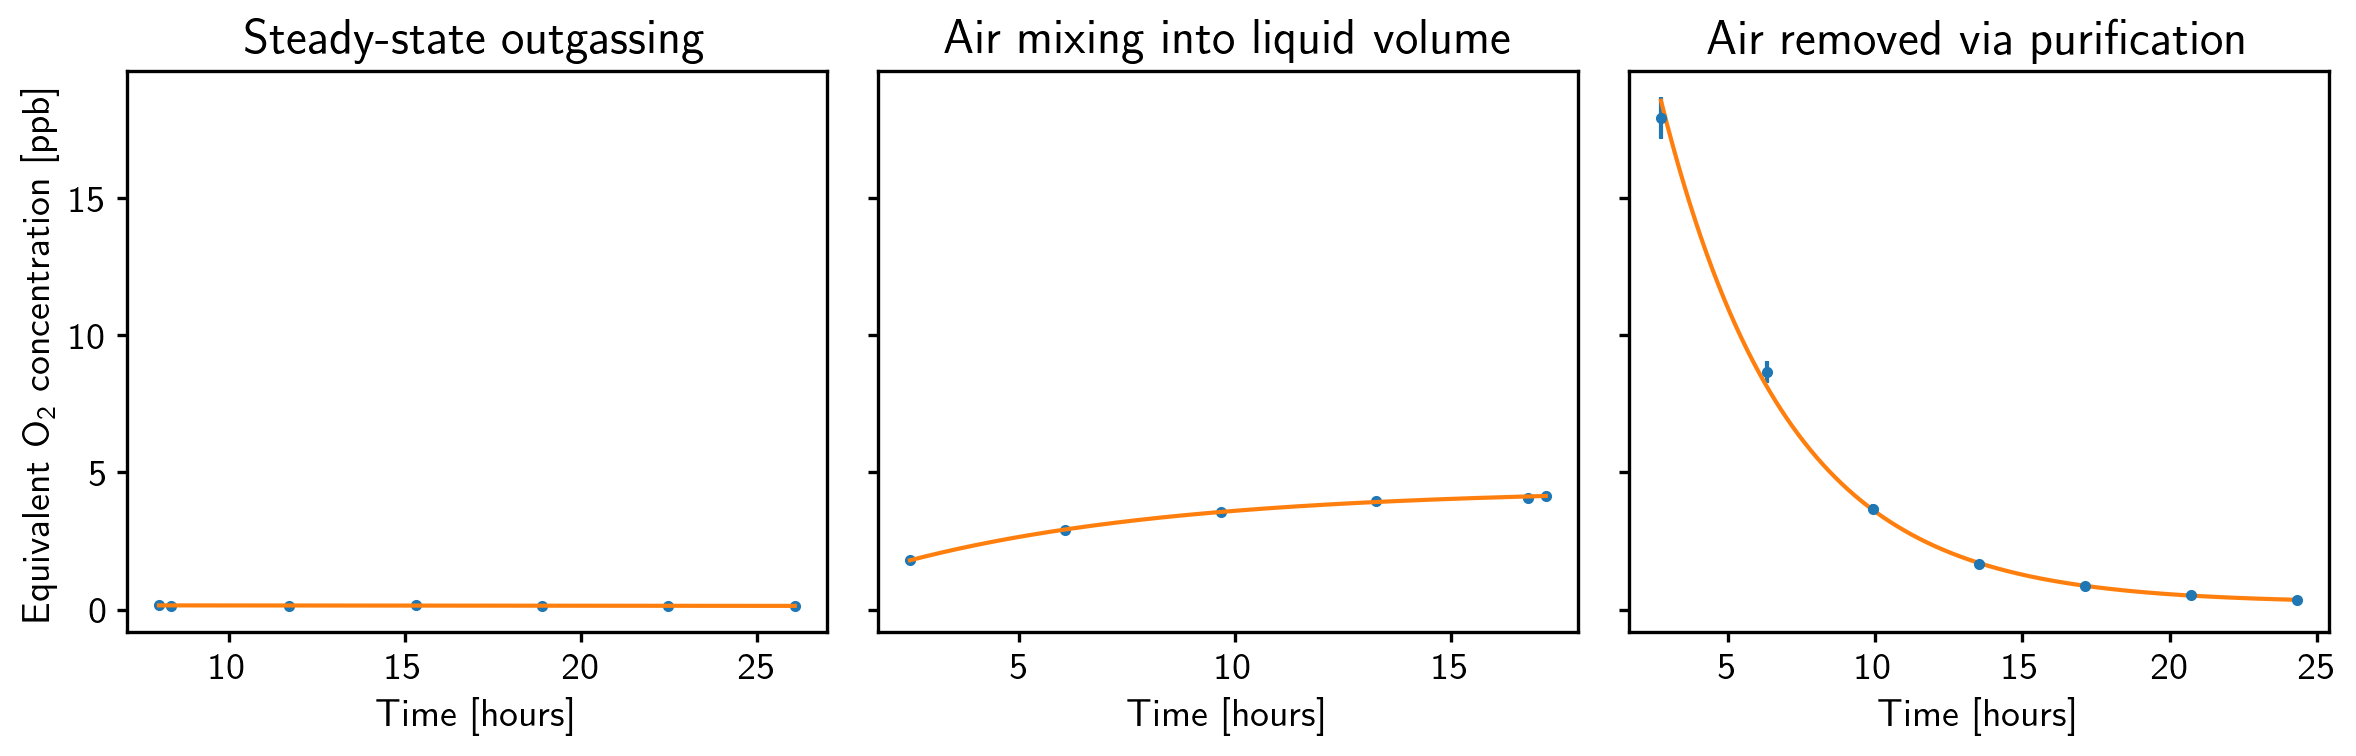

In [36]:
fig,ax = plt.subplots(1,3,sharey=True,figsize=(12,4))
ax[0].errorbar(outgasTimes/3600.,outgasConcs,yerr=outgasConcErrors,fmt='.')
ax[0].errorbar(outgasTimeArray/3600.,outgasConcArray)
ax[0].set_xlabel('Time [hours]')
ax[0].set_ylabel('Equivalent O$_2$ concentration [ppb]')
ax[0].set_title('Steady-state outgassing')
ax[1].errorbar(dosingTimes/3600.,dosingConcs,yerr=dosingConcErrors,fmt='.')
ax[1].errorbar(dosingTimeArray/3600.,dosingConcArray)
ax[1].set_xlabel('Time [hours]')
ax[1].set_title('Air mixing into liquid volume')
ax[2].errorbar(fitTimes/3600.,fitConcs,yerr=fitConcErrors,fmt='.',label='Purification raw')
ax[2].plot(timeArray/3600.,concArray,label='Purification fit')
ax[2].set_xlabel('Time [hours]')
ax[2].set_title('Air removed via purification')
fig.tight_layout()
# fig.savefig('panels.png',bbox_inches='tight')

In [38]:
def efficiency(ef,deltaef,f,deltaf):
    e = ef/f
    deltae = np.sqrt((deltaef/f)**2+(ef*deltaf/f**2)**2)
    print('Efficiency: {:.3f}+/-{:.3f}'.format(e,deltae))
    return e,deltae
    
#e_dose,de_dose = efficiency(ef,deltaef,f_dose,df_dose)
e_saes,de_saes = efficiency(ef,deltaef,f_saes,df_saes)

fig,ax = plt.subplots()
ax.axvline([1.],ls='--',lw=2,color='navy',label='SAES')
#ax.errorbar([e_dose],[1],xerr=[de_dose],markersize=10,marker='.',color='dodgerblue',label=' SCP w/ $f$ from dosing')
ax.errorbar([e_saes],[2],xerr=[de_saes],markersize=10,marker='.',color='plum',label='SCP w/ $f$ from SAES data')
ax.set_ylim([0,3])
ax.set_xlim([0,2])
ax.set_yticks([])
#ax.set_xticklabels(['Dosing','SAES data'])
#ax.set_xlim([0,3])
#ax.set_ylabel('')
ax.set_xlabel(r'Efficiency, $\varepsilon$')
ax.set_title(r'Measurements of $\varepsilon$ for the SCP')
ax.legend(loc='upper right')
fig.savefig('eps_plot.png',bbox_inches='tight')

NameError: name 'ef' is not defined